# 데이터셋 로드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import pandas as pd

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import (
    train_test_split,
    RepeatedStratifiedKFold,
    RandomizedSearchCV,
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, balanced_accuracy_score,
                             f1_score, roc_auc_score, log_loss,
                             top_k_accuracy_score)

# 샘플링 범위(무작위 탐색용)
from scipy.stats import randint, uniform
from sklearn.metrics import make_scorer, top_k_accuracy_score


df = pd.read_csv('/content/drive/My Drive/cpp_dataset.csv')

In [3]:
# Cpp Feature
features = [
    "code_size",
    "total_lines",
    "blank_ratio",
    "comment_ratio",
    "num_funcs",
    "avg_func_length",
    "max_control_depth",
    "control_count",
    "unique_identifiers",
    "token_count"
] + [f'vec_{i}' for i in range(768)]

X = df[features]
y = df["model"]

le = LabelEncoder()               # 문자열 → 정수 라벨
y  = le.fit_transform(df["model"])

le = LabelEncoder()               # 문자열 → 정수 라벨
y  = le.fit_transform(df["model"])

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

In [4]:
def custom_top_k_accuracy(y_true, y_proba, k=2):
    correct = 0
    for i in range(len(y_true)):
        true_label = y_true[i]
        if true_label == 0:
            # 0일 때는 예측이 0이어야만 correct
            pred_label = np.argmax(y_proba[i])
            if pred_label == 0:
                correct += 1
        else:
            # 1~5일 때는 y_proba에서 1~5 라벨만 고려해 top2를 뽑음
            proba = y_proba[i]
            # 1~5 라벨에 해당하는 인덱스만 추출
            relevant_indices = np.array([1, 2, 3, 4, 5])
            # 해당 인덱스의 확률만 뽑음
            relevant_proba = proba[relevant_indices]
            # 확률이 높은 순서로 1~5 라벨 중 top2 뽑기
            top2_indices = np.argsort(relevant_proba)[-2:][::-1]
            top2_labels = relevant_indices[top2_indices]
            if true_label in top2_labels:
                correct += 1
    return correct / len(y_true)


# 시각화 함수

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.family'] = 'sans-serif'  # 기본값은 DejaVu Sans
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']  # 명시적으로 지정

def plot_classification_report(y_true, y_pred, class_names, model_name):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    df_report = df_report.drop(columns=['support'], errors='ignore')

    plt.figure(figsize=(10, 6))
    sns.heatmap(df_report, annot=True, cmap='Blues', fmt='.2f')
    plt.title(f"{model_name} - Classification Report")
    plt.show()

def plot_confusion(y_true, y_pred, class_names, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

# RF test

Top-1 accuracy : 0.786
Balanced acc. : 0.6833333333333335
Macro F1      : 0.6969860786809039
Weighted F1   : 0.7860977137447458
Top-2 accuracy: 0.896
Log-loss      : 0.6956649295555312
ROC-AUC macro : 0.9426573333333333


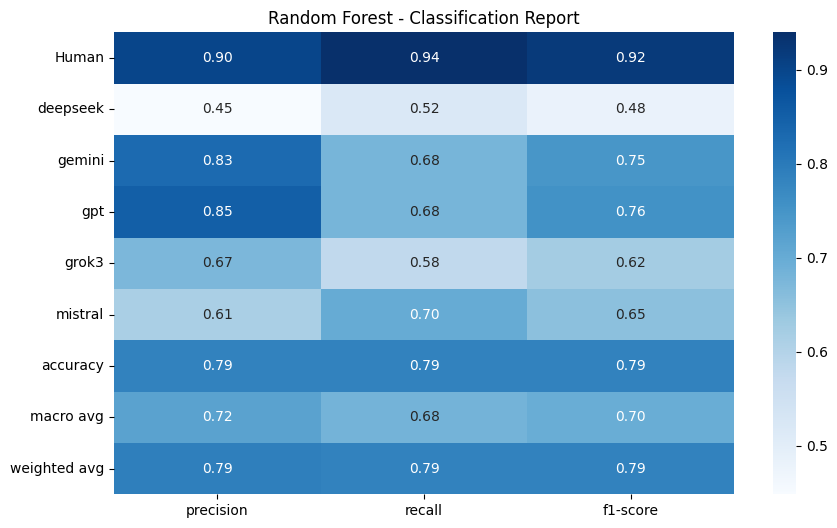

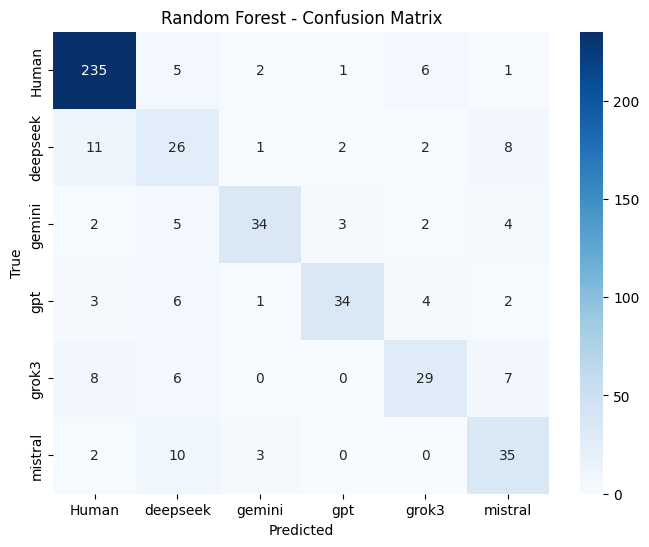

In [6]:
python_multilabel_classifier = joblib.load("/content/drive/My Drive/cpp_multilabel_classifier.joblib")
multiclassification_model = python_multilabel_classifier.get("model")
y_pred  = multiclassification_model.predict(X_test)
y_proba = multiclassification_model.predict_proba(X_test)

# 결과 출력
print("Top-1 accuracy :", accuracy_score(y_test, y_pred))
print("Balanced acc. :", balanced_accuracy_score(y_test, y_pred))
print("Macro F1      :", f1_score(y_test, y_pred, average='macro'))
print("Weighted F1   :", f1_score(y_test, y_pred, average='weighted'))
print("Top-2 accuracy:", custom_top_k_accuracy(y_test, y_proba))
print("Log-loss      :", log_loss(y_test, y_proba))
print("ROC-AUC macro :", roc_auc_score(y_test, y_proba,
                                       multi_class='ovr', average='macro'))

plot_classification_report(y_test, y_pred, le.classes_, "Random Forest")
plot_confusion(y_test, y_pred, le.classes_, "Random Forest")

# XGBoost Test

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:12:36] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


Top-1 accuracy : 0.816
Balanced acc. : 0.7306666666666667
Macro F1      : 0.7362729260692734
Weighted F1   : 0.8178593731714444
Top-2 accuracy: 0.92
Log-loss      : 0.5450309643828773
ROC-AUC macro : 0.9622053333333334


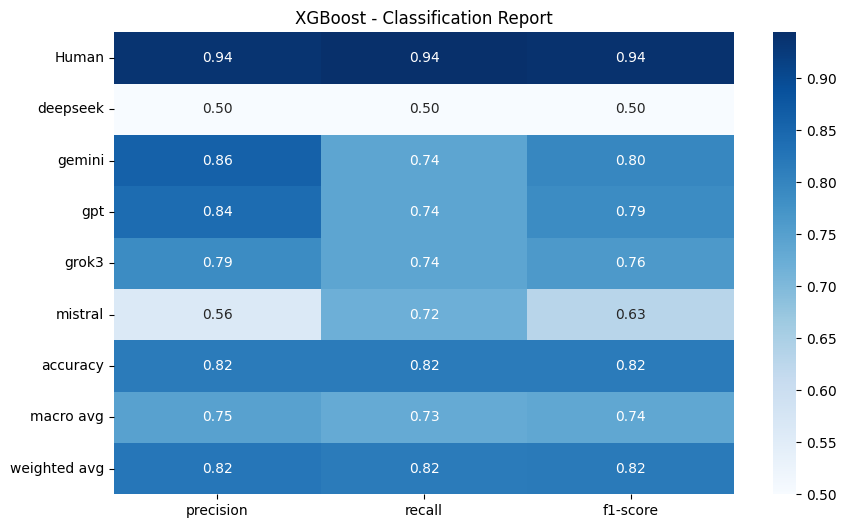

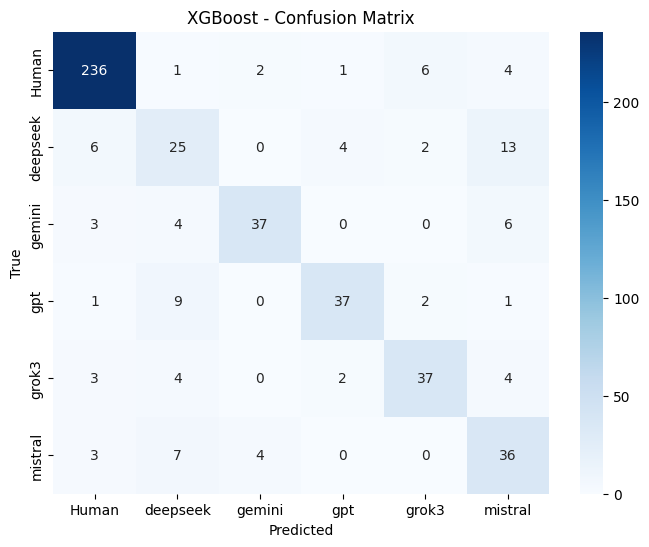

In [7]:
import joblib
python_multilabel_classifier = joblib.load("/content/drive/My Drive/cpp_xgb_top2.joblib")
y_pred  = python_multilabel_classifier.predict(X_test)
y_proba = python_multilabel_classifier.predict_proba(X_test)

# 결과 출력
print("Top-1 accuracy :", accuracy_score(y_test, y_pred))
print("Balanced acc. :", balanced_accuracy_score(y_test, y_pred))
print("Macro F1      :", f1_score(y_test, y_pred, average='macro'))
print("Weighted F1   :", f1_score(y_test, y_pred, average='weighted'))
print("Top-2 accuracy:", custom_top_k_accuracy(y_test, y_proba))
print("Log-loss      :", log_loss(y_test, y_proba))
print("ROC-AUC macro :", roc_auc_score(y_test, y_proba,
                                       multi_class='ovr', average='macro'))

plot_classification_report(y_test, y_pred, le.classes_, "XGBoost")
plot_confusion(y_test, y_pred, le.classes_, "XGBoost")

# SVM Test

Top-1 accuracy : 0.946
Balanced acc. : 0.918
Macro F1      : 0.9179798731373737
Weighted F1   : 0.9459879238824243
Top-2 accuracy: 0.978
Log-loss      : 0.22679329333313922
ROC-AUC macro : 0.9963025185185185


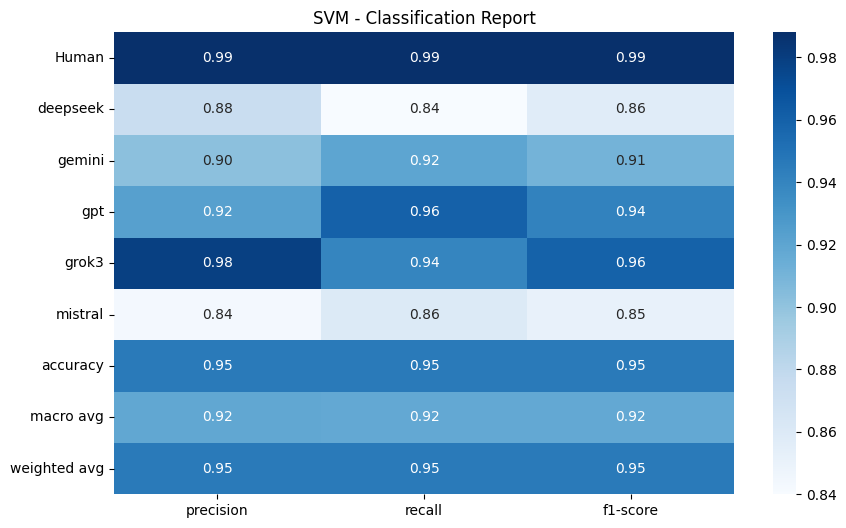

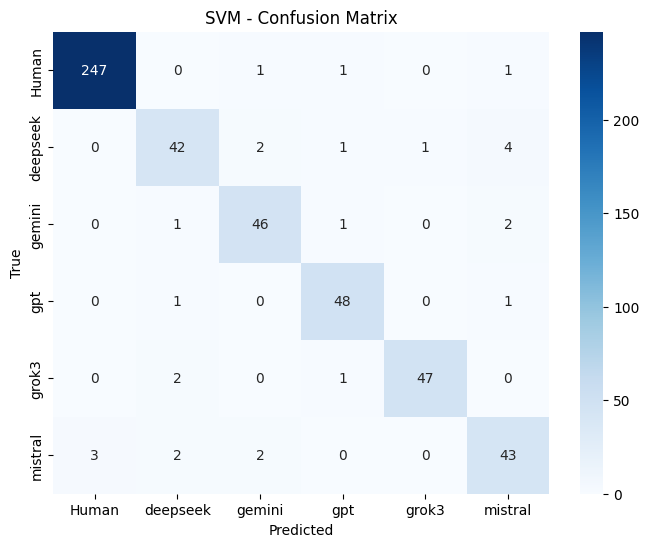

In [8]:
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
python_multilabel_classifier = joblib.load("/content/drive/My Drive/svm_multi_cpp_version2.joblib")
y_pred  = python_multilabel_classifier.predict(X_test)
y_proba = python_multilabel_classifier.predict_proba(X_test)

# 결과 출력
print("Top-1 accuracy :", accuracy_score(y_test, y_pred))
print("Balanced acc. :", balanced_accuracy_score(y_test, y_pred))
print("Macro F1      :", f1_score(y_test, y_pred, average='macro'))
print("Weighted F1   :", f1_score(y_test, y_pred, average='weighted'))
print("Top-2 accuracy:", custom_top_k_accuracy(y_test, y_proba))
print("Log-loss      :", log_loss(y_test, y_proba))
print("ROC-AUC macro :", roc_auc_score(y_test, y_proba,
                                       multi_class='ovr', average='macro'))

plot_classification_report(y_test, y_pred, le.classes_, "SVM")
plot_confusion(y_test, y_pred, le.classes_, "SVM")

# Matplotlib Assemble

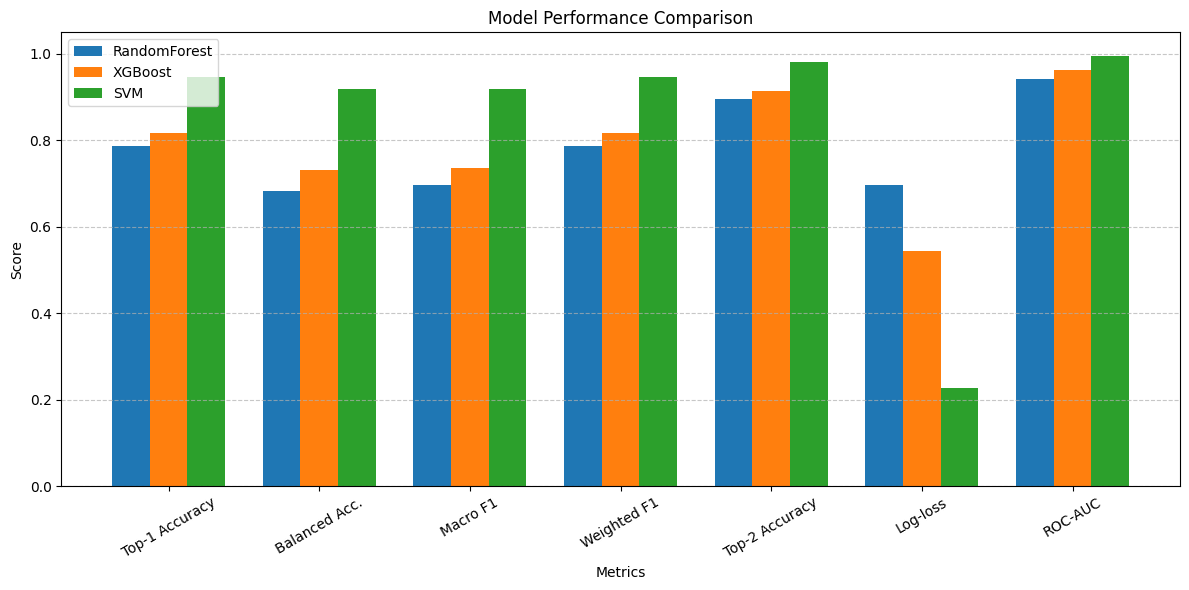

In [9]:
import matplotlib.pyplot as plt
import numpy as np

metrics = ['Top-1 Accuracy', 'Balanced Acc.', 'Macro F1', 'Weighted F1', 'Top-2 Accuracy', 'Log-loss', 'ROC-AUC']

random_forest_scores = [0.786, 0.6833333333333335, 0.6969860786809039, 0.7860977137447458, 0.896, 0.6956649295555312, 0.9426573333333333]
xgboost_scores       = [0.816, 0.7306666666666667, 0.7362729260692734, 0.8178593731714444, 0.914, 0.5450309643828773, 0.9622053333333334]
svm_scores           = [0.946, 0.918, 0.9179798731373737, 0.9459879238824243, 0.982, 0.22679329333313916, 0.9963025185185185]

# 바 차트용 위치 설정
x = np.arange(len(metrics))
width = 0.25

# 시각화
plt.figure(figsize=(12, 6))
plt.bar(x - width, random_forest_scores, width, label='RandomForest')
plt.bar(x, xgboost_scores, width, label='XGBoost')
plt.bar(x + width, svm_scores, width, label='SVM')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics, rotation=30)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()